In [1]:
import cv2
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
df=pd.read_csv("train.csv")

In [3]:
df=df[df.classname.isin(['face_with_mask','face_no_mask'])]

In [4]:
df.head()

,name,x1,x2,y1,y2,classname
0,2756.png,69,126,294,392,face_with_mask
1,2756.png,505,10,723,283,face_with_mask
4,6098.jpg,360,85,728,653,face_no_mask
7,4591.png,239,9,522,342,face_with_mask
11,5525.jpg,262,18,484,319,face_no_mask


In [5]:
df.shape

(5749, 6)

In [6]:
len(df.name.unique())

3390

In [7]:
df.isnull().sum(axis=0)

name         0
x1           0
x2           0
y1           0
y2           0
classname    0
dtype: int64

In [8]:
df.classname.value_counts()

face_with_mask    4180
face_no_mask      1569
Name: classname, dtype: int64

In [9]:
DIR_IMAGES=".\Medical mask\Medical mask\Medical Mask\images"

In [10]:
def plot_img(image_name):
    fig, ax = plt.subplots(1, 2, figsize = (14, 14))
    ax = ax.flatten()
    bbox = df[df['name'] == image_name]
    print(bbox)
    img_path = os.path.join(DIR_IMAGES, image_name)
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    image /= 255.0
    image2 = image
    ax[0].set_title('Original Image')
    ax[0].imshow(image)
    for idx, row in bbox.iterrows():
        x1 = row['x1']
        y1 = row['x2']
        x2 = row['y1']
        y2 = row['y2']
        label = row['classname']
        cv2.rectangle(image2, (int(x1),int(y1)), (int(x2),int(y2)), (255,0,0), 3)
        font = cv2.FONT_HERSHEY_SIMPLEX
        cv2.putText(image2, label, (int(x1),int(y1+30)), font, 1, (255,0,0), 2)
    
    ax[1].set_title('Image with Bondary Box')
    ax[1].imshow(image2)

    plt.show()

          name   x1  x2   y1   y2       classname
6497  2647.png   51   8  396  426  face_with_mask
6498  2647.png  378  45  690  495  face_with_mask


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


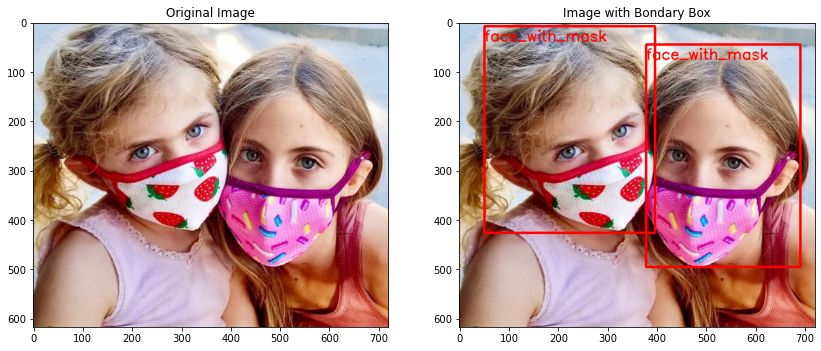

In [11]:
plot_img("2647.png")

In [13]:
# loop over the image paths
data=[]
labels=[]
for idx, row in tqdm(df.iterrows()):
    img_path = os.path.join(DIR_IMAGES, row['name'])
    image = cv2.imread(img_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
    x1 = row['x1']
    y1 = row['x2']
    x2 = row['y1']
    y2 = row['y2']
    image = image[y1:y2,x1:x2]
    image.setflags(write=1)
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.preprocessing.image.img_to_array(image)
    image = image.copy()
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    
    # extract the class label from the filename
    label = row['classname']
    # update the data and labels lists, respectively
    data.append(image)
    labels.append(label)


5749it [12:21,  7.75it/s]


In [14]:
# convert the data and labels to NumPy arrays
data = np.array(data, dtype="float32")
labels = np.array(labels)

In [18]:
np.save("./variables/data.npy",data)
np.save("./variables/labels.npy",labels)

In [12]:
data = np.load("./variables/data.npy")
labels = np.load("./variables/labels.npy")

In [13]:
# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = tf.keras.utils.to_categorical(labels)

In [14]:
(trainX, testX, trainY, testY) = train_test_split(data, labels,test_size=0.20, stratify=labels, random_state=42)

In [15]:
# construct the training image generator for data augmentation
aug = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=20,zoom_range=0.15,width_shift_range=0.2,
                                                height_shift_range=0.2,shear_range=0.15,horizontal_flip=True,
                                                fill_mode="nearest")

In [16]:
# load the MobileNetV2 network
baseModel = tf.keras.applications.MobileNetV2(weights="imagenet", include_top=False,
                                              input_tensor=tf.keras.layers.Input(shape=(224, 224, 3)))

C:\Users\PARAKH\anaconda3\envs\parakh-py\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


In [17]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

In [18]:
# the base model
headModel = baseModel.output
headModel = tf.keras.layers.AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = tf.keras.layers.Flatten(name="flatten")(headModel)
headModel = tf.keras.layers.Dense(128, activation="relu")(headModel)
headModel = tf.keras.layers.Dropout(0.5)(headModel)
headModel = tf.keras.layers.Dense(2, activation="softmax")(headModel)

In [19]:
for layer in baseModel.layers:
    layer.trainable = False

In [20]:
model = tf.keras.Model(inputs=baseModel.input, outputs=headModel)

In [21]:
# compile our model
opt = tf.keras.optimizers.Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [22]:
# train the head of the network
history = model.fit(
    aug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, min_delta=0.0001)])

  ...
    to  
  ['...']
Train for 143 steps, validate on 1150 samples
Epoch 1/20
143/143 [==============================] - 572s 4s/step - loss: 0.4989 - accuracy: 0.7635 - val_loss: 0.4275 - val_accuracy: 0.7839
Epoch 2/20
143/143 [==============================] - 93s 653ms/step - loss: 0.3315 - accuracy: 0.8572 - val_loss: 0.4020 - val_accuracy: 0.8161
Epoch 3/20
143/143 [==============================] - 96s 670ms/step - loss: 0.2866 - accuracy: 0.8741 - val_loss: 0.3723 - val_accuracy: 0.8339
Epoch 4/20
143/143 [==============================] - 94s 658ms/step - loss: 0.2467 - accuracy: 0.8960 - val_loss: 0.3532 - val_accuracy: 0.8482
Epoch 5/20
143/143 [==============================] - 94s 656ms/step - loss: 0.2441 - accuracy: 0.8934 - val_loss: 0.2891 - val_accuracy: 0.8723
Epoch 6/20
143/143 [==============================] - 97s 676ms/step - loss: 0.2325 - accuracy: 0.8988 - val_loss: 0.2644 - val_accuracy: 0.8839
Epoch 7/20
143/143 [==============================] - 97s 678

In [24]:
model.save('./Model/Mask_detection/model.h5')

In [25]:
# make predictions on the testing set
predIdxs = model.predict(testX, batch_size=BS)
predIdxs = np.argmax(predIdxs, axis=1)

In [26]:
# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,target_names=lb.classes_))

                precision    recall  f1-score   support

  face_no_mask       0.98      0.64      0.78       314
face_with_mask       0.88      0.99      0.93       836

      accuracy                           0.90      1150
     macro avg       0.93      0.82      0.85      1150
  weighted avg       0.91      0.90      0.89      1150



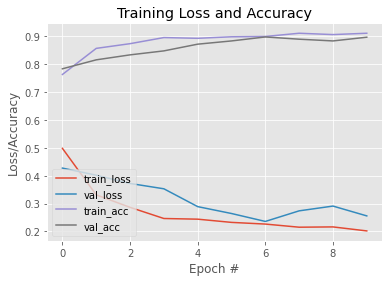

In [28]:
# plot the training loss and accuracy
N = 10
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), history.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), history.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("plot.png")